In [2]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
import json

sys.path.append('./')

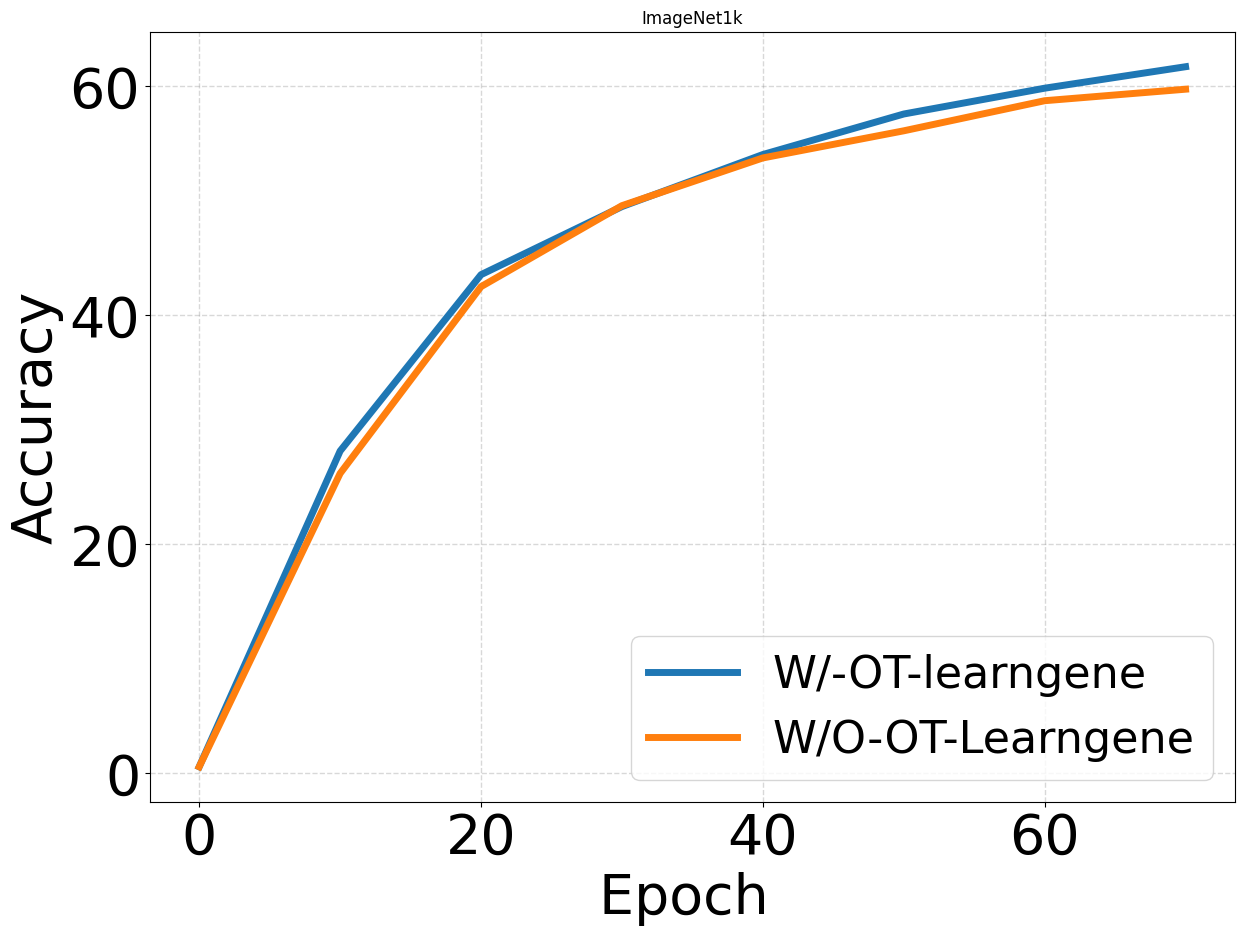

In [9]:
def ret_acc(file_name, acc_1_or_5):
    # 读取文件并解析为字典列表
    with open(file_name, 'r') as f:
        data_list = [json.loads(line) for line in f.readlines()]

    accuracies = []
    for data in data_list:
        if "epoch" in data:
            #print(data["epoch"])
            if data["epoch"]%10 == 0:
                accuracies.append(data[acc_1_or_5])
    return accuracies

fig, axs = plt.subplots(1, 1, figsize=(14, 10), sharey=True)

# 设置网格线的颜色
axs.grid(color='gray', linestyle='--', linewidth=1, alpha=0.3)

# 设置图片的背景颜色
axs=plt.gca()
axs.patch.set_facecolor("white")                   
axs.patch.set_alpha(0.15) 

# 横纵坐标的含义
plt.xlabel("Epoch ",fontsize=40)
plt.ylabel("Accuracy",fontsize=40)
plt.tick_params(labelsize=40)
axs.set_title('ImageNet1k')
        
# axs.set_ylim(60,90)
            

            
epochs = [i for i in range(0, 71, 10)]
ours_accuracies = ret_acc('./checkpoint/deit/log.txt', "test_acc1")
baseline_accuracies = ret_acc('./checkpoint/deit_avg_multilayer_distill/log.txt', "test_acc1")

axs.plot(epochs, ours_accuracies, '-', label="W/-OT-learngene",linewidth=5)
axs.plot(epochs, baseline_accuracies[:8], '-', label="W/O-OT-Learngene",linewidth=5)
    
axs.legend(loc=0,fontsize=32)
#legend = axs.legend(loc=8,fontsize=16)
#legend.remove()
    
#fig.suptitle(str((i+1)*10)+'-shot')
        
plt.show()
fig.savefig('fig/fig_ot_accuracy_top1.pdf',bbox_inches='tight')
plt.close()

In [7]:
import torch
from torch import nn, optim
from torch.cuda.amp import autocast

# 定义模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Model().cuda()

# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 定义训练数据和标签
inputs = torch.randn(32, 100).cuda().half()
labels = torch.randint(0, 10, (32,)).cuda()

# 进行混合精度训练
for i in range(100):
    optimizer.zero_grad()

    with autocast():
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print('Epoch {}: Loss={}'.format(i, loss.item()))
for name, param in model.named_parameters():
    print(f'{name}: {param.dtype}')
    
for name, buffer in model.named_buffers():
    print(f'{name}: {buffer.dtype}')  

print(inputs.dtype)

Epoch 0: Loss=2.28765869140625
Epoch 10: Loss=2.216156005859375
Epoch 20: Loss=2.146484375
Epoch 30: Loss=2.07843017578125
Epoch 40: Loss=2.011260986328125
Epoch 50: Loss=1.94464111328125
Epoch 60: Loss=1.87799072265625
Epoch 70: Loss=1.811370849609375
Epoch 80: Loss=1.744842529296875
Epoch 90: Loss=1.6788330078125
fc1.weight: torch.float32
fc1.bias: torch.float32
fc2.weight: torch.float32
fc2.bias: torch.float32
torch.float16


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

# 创建模型、优化器和损失函数
model = nn.Sequential(nn.Linear(10, 5), nn.ReLU(), nn.Linear(5, 1)).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 创建随机输入和标签
inputs = torch.randn(32, 10).cuda()
labels = torch.randn(32, 1).cuda()

# 创建 GradScaler 对象和 autocast 上下文管理器
scaler = GradScaler()
with autocast(enabled=True, dtype=torch.float16):
    # 前向传递和反向传递
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    for name, param in model.named_parameters():
        print(f'{name}: {param.dtype}')
    for name, buffer in model.named_buffers():
        print(f'{name}: {buffer.dtype}')  
    print(outputs.dtype)
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(name, param.grad.dtype)
    

0.weight: torch.float32
0.bias: torch.float32
2.weight: torch.float32
2.bias: torch.float32
torch.float16
0.weight torch.float32
0.bias torch.float32
2.weight torch.float32
2.bias torch.float32
